In [1]:
cd D:\zzCoursera proj\Predict house prices

D:\zzCoursera proj\Predict house prices


### importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
import tensorflow.compat.v1 as tf ################## PIECE OF CODE ADDED ######################
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.


### importing data

In [3]:
column_names = ['serial','date','age','distance','stores','latitude','longitude','price']
df = pd.read_csv('data.csv', names = column_names)
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


### checking missing data

In [4]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

### normalising data

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [5]:
df = df.iloc[:,1:]
df_norm = (df-df.mean())/df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


### Converting Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [6]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred*y_std +y_mean)

int(convert_label_value(0.350088)) # took a random value from above table 

14263

### creating training & test sets

In [7]:
x = df_norm.iloc[:,:6] # we use all the rows and first 6 columns 
x.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


### Selecting Labels

In [8]:
y = df_norm.iloc[:,-1] # we use all the rows and first 6 columns 
y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64


##### We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [9]:
x_arr = x.values
y_arr = y.values

print('features array shape :' ,x_arr.shape)

print('labels array shape :' ,y_arr.shape)

features array shape : (5000, 6)
labels array shape : (5000,)


### Train/Test splitting

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [10]:
x_train , x_test , y_train , y_test =train_test_split(x_arr , y_arr , test_size = 0.05 , 
                 random_state = 0) 

print('Training set:',x_train.shape , y_train.shape)
print('Test set:',x_test.shape,y_test.shape)

Training set: (4750, 6) (4750,)
Test set: (250, 6) (250,)


### creating model

In [11]:
def get_model():
    model = Sequential([        
        Dense(10,input_shape = (6,),activation = 'relu'),
        Dense(20,activation = 'relu'),
        Dense(5,activation = 'relu'),
        Dense(1)
        # so 4 networks in total and we have given the dense nodes inputs  
    ])
    model.compile(
    loss='mse',
    optimizer = 'adam'
    )
    return model 

get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


### training model

In [13]:
es_cb = EarlyStopping(monitor = 'val_loss',patience=5)

model = get_model()

preds_on_untrained = model.predict(x_test)

history = model.fit(
x_train , y_train,
    validation_data = (x_test,y_test),
    epochs = 100,
    callbacks = [es_cb]
)

Train on 4750 samples, validate on 250 samples
Epoch 1/100
4750/4750 [==============================] - 1s 154us/sample - loss: 0.6451 - val_loss: 0.2444
Epoch 2/100
4750/4750 [==============================] - 0s 48us/sample - loss: 0.2287 - val_loss: 0.1678
Epoch 3/100
4750/4750 [==============================] - 0s 51us/sample - loss: 0.1821 - val_loss: 0.1547
Epoch 4/100
4750/4750 [==============================] - 0s 45us/sample - loss: 0.1708 - val_loss: 0.1519
Epoch 5/100
4750/4750 [==============================] - 0s 60us/sample - loss: 0.1657 - val_loss: 0.1492
Epoch 6/100
4750/4750 [==============================] - 0s 49us/sample - loss: 0.1620 - val_loss: 0.1519
Epoch 7/100
4750/4750 [==============================] - 0s 62us/sample - loss: 0.1603 - val_loss: 0.1475
Epoch 8/100
4750/4750 [==============================] - 0s 52us/sample - loss: 0.1584 - val_loss: 0.1467
Epoch 9/100
4750/4750 [==============================] - 0s 48us/sample - loss: 0.1577 - val_loss: 0.145

### plot training and validation loss

Using `plot_loss` helper function to take a look training and validation loss.

In [21]:
######## USING THE .py FILE IN THE DIRECTORY ########

import matplotlib.pyplot as plt

column_names = ['serial', 'date', 'age', 'distance', 'stores', 'latitude', 'longitude', 'price']

def plot_loss(history):
    h = history.history
    x_lim = len(h['loss'])
    plt.figure(figsize=(8, 8))
    plt.plot(range(x_lim), h['val_loss'], label = 'Validation Loss')
    plt.plot(range(x_lim), h['loss'], label = 'Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

def plot_predictions(preds, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds, y_test, 'ro')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    plt.xlim([-0.5, 0.5])
    plt.ylim([-0.5, 0.5])
    plt.plot([-0.5, 0.5], [-0.5, 0.5], 'b--')
    plt.show()
    return

def compare_predictions(preds1, preds2, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds1, y_test, 'ro', label='Untrained Model')
    plt.plot(preds2, y_test, 'go', label='Trained Model')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    
    y_min = min(min(y_test), min(preds1), min(preds2))
    y_max = max(max(y_test), max(preds1), max(preds2))
    
    plt.xlim([y_min, y_max])
    plt.ylim([y_min, y_max])
    plt.plot([y_min, y_max], [y_min, y_max], 'b--')
    plt.legend()
    plt.show()
    return

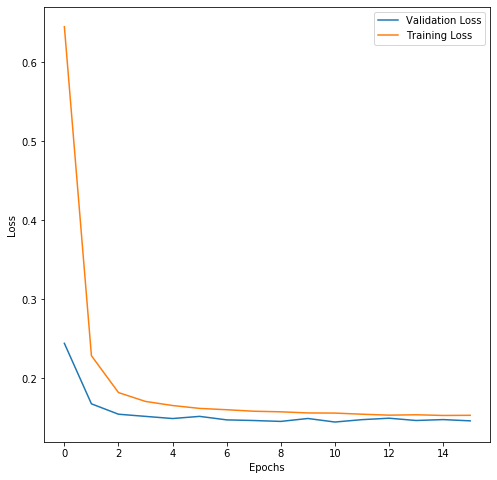

In [22]:
plot_loss(history)

### Plotting Raw Predictions

Using `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

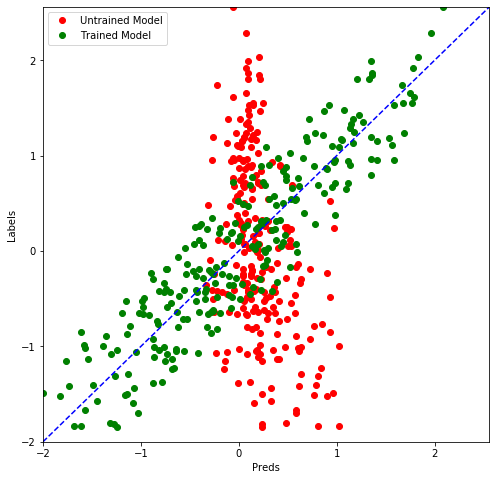

In [23]:
preds_on_trained = model.predict(x_test)
compare_predictions(preds_on_untrained , preds_on_trained , y_test)

### plotting price predictions.

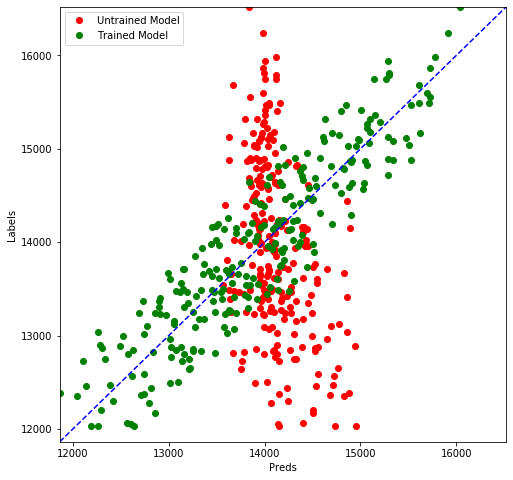

In [25]:
price_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_trained = [convert_label_value(y) for y in preds_on_trained]
price_test = [convert_label_value(y) for y in y_test]


compare_predictions(price_untrained,price_trained ,price_test)